In [1]:
import keras
import tensorflow as tf
from pathlib import Path
import os
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.python.client import device_lib

In [2]:
# GPU

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12145432951529560977
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12493603256101144069
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [5]:
images, labels = [], []
files = glob.glob("./dataset/*.jpg")

height = 50
width = 200
batch_size = 16

In [6]:
len(files)

22299

In [7]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    indx = np.arange(size)
    if shuffle:
        np.random.shuffle(indx)
    train = int(size * train_size)
    x_train, y_train = images[indx[:train]], labels[indx[:train]]
    x_test, y_test = images[indx[train:]], labels[indx[train:]]
    return x_train, x_test, y_train, y_test

In [8]:
def bild_data(files):
    for file in files:
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (width, height))
        image = image.astype(np.float32)
        images.append(image)
        labels.append(file.split(os.path.sep)[-1].split(".jpg")[0])

In [9]:
def text_to_labels(text, unique_symbols):
    return list(map(lambda x: unique_symbols.index(x), text))
def labels_to_text(labels, unique_symbols):
    return ''.join(list(map(lambda x: unique_symbols[int(x)], labels)))

In [10]:
bild_data(files)
max_length = max([len(label) for label in labels])

In [11]:
import pandas as pd
def count_labels(labels):
    return pd.Series(list(''.join(list(map(lambda x: ''.join(x), labels))))).value_counts()

In [12]:
count_labels(labels)

I    3080
3    2797
2    2766
9    2691
1    2496
L    2449
E    2319
f    2171
l    2162
Q    2146
5    2116
e    2076
t    2071
i    2067
k    2053
J    2037
z    2030
C    1990
p    1978
V    1976
a    1907
Z    1876
O    1830
K    1812
b    1810
h    1808
j    1805
N    1805
F    1793
n    1792
4    1789
G    1769
6    1696
7    1690
s    1677
c    1662
H    1641
T    1639
d    1632
y    1631
g    1630
w    1625
8    1623
M    1608
m    1607
v    1606
Y    1601
R    1588
u    1568
D    1542
P    1542
x    1535
q    1518
X    1509
B    1489
A    1485
U    1479
r    1477
W    1469
S    1459
dtype: int64

In [13]:
unique_symbols = sorted(list({char for label in labels for char in label}))
labels = [text_to_labels(label, unique_symbols) for label in labels]

In [14]:
for i in labels:
    if len(i) != 5:
        print(i)

In [15]:
x_train, x_test, y_train, y_test = split_data(np.array(images), np.array(labels, dtype=np.int64))

In [16]:
x_train.shape

(17839, 50, 200)

In [17]:
x_train = tf.transpose(x_train, perm=[0, 2, 1])
x_test = tf.transpose(x_test, perm=[0, 2, 1])

In [18]:
x_train, x_test = np.expand_dims(x_train, axis=3), np.expand_dims(x_test, axis=3)

In [19]:
x_train.shape

(17839, 200, 50, 1)

In [20]:
y_test.shape

(4460, 5)

In [21]:
data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

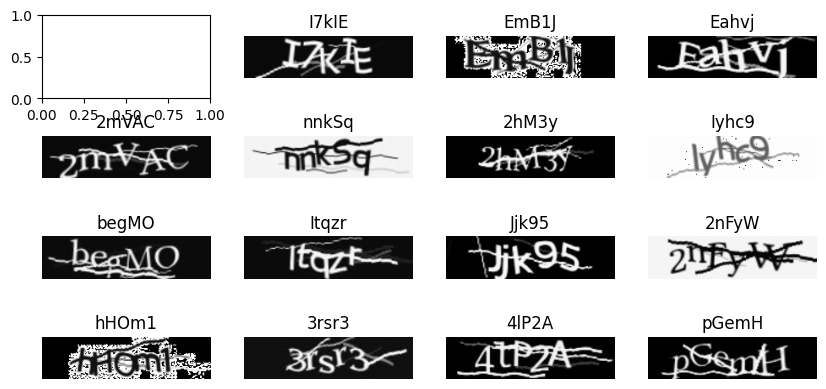

In [22]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for i in range(16):
    for batch in data_train.take(i):
        images = batch[0]
        labels = batch[1]
        img = (images * 255).numpy().astype("uint8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        label = labels_to_text(labels, unique_symbols)
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
def update_data(img, label):
    return {"image": img, "label": label}

In [24]:
data_test = data_test.map(
        update_data, num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
data_train = data_train.map(
        update_data, num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
data_test

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, 5), dtype=tf.int64, name=None)}>

In [33]:
data_train

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, 5), dtype=tf.int64, name=None)}>